# Lab session 2 : Word Embeddings and their evaluation

In this session we will use the following corpuses to train embeddings : 
- A political media corpus, consisting of tweets from politicians
- Economical news
- A corpus containing stories of films from the IMDB
- A corpus containing human-rated similarities between

## 1. Write a function that cleans a given text, i.e :
 - Lower-case the text
 - Tokenizes
 - Separates sentences
 - Detects multi-word expressions (i.e. "New", York" becomes "New York")

## 2. Build the 3 cleaned corpuses with your cleaning function. (1 corpus = 1 list of cleaned and tokenized sentences).

## 3. Train a Word2Vec model with Gensim for the 3 corpuses, and explore the most similar words to "man", "woman", "politician', etc. for the corpuses. 

## 4. Export the embeddings as two .tsv files to use projector.tensorflow.org interactive visualisation. 

## 5. Write an evaluation function that computes the correlation coefficient between human-rated similarity and Word2Vec's cosine similarity




In [0]:
! wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv
! wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv

--2020-02-12 13:30:29--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 13.226.55.102, 13.226.55.97, 13.226.55.25, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|13.226.55.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4309577 (4.1M) [application/octet-stream]
Saving to: ‘Political-media-DFE.csv’

Political-media-DFE 100%[===================>]   4.11M  22.0MB/s    in 0.2s    

2020-02-12 13:30:29 (22.0 MB/s) - ‘Political-media-DFE.csv’ saved [4309577/4309577]

--2020-02-12 13:30:32--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 13.226.55.102, 13.226.55.97, 13.226.55.25, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|13.226.55.102|:443... connected.

WARNING : To get the movies_metadata.csv file, you need to upload in the runtime the file that is located in this drive. 

In [0]:
import pandas as pd
df_pol = pd.read_csv('Political-media-DFE.csv', encoding='latin-1')
df_eco = pd.read_csv('Full-Economic-News-DFE-839861.csv', encoding='latin-1')
df_movies = pd.read_csv('movies_metadata.csv')
df_sims = pd.read_csv('1377883875_similar_word_combinations-1.csv', encoding='latin-1')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's print some examples so we can see the preprocessing we have to do: 



In [0]:
df_pol.text.iloc[0]

'RT @nowthisnews: Rep. Trey Radel (R- #FL) slams #Obamacare. #politics https://t.co/zvywMG8yIH'

In [0]:
df_eco.text.iloc[0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [0]:
df_movies.overview.iloc[0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

We can see that we'll have many problems : 
- hashtags and urls for the twitter database; 
- some html code for the economics news database

Let's do our preprocessing : 

## 1. Write a function that cleans a given text, i.e :

In [0]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

In [0]:
remove_hashtags(TweetTokenizer().tokenize(df_pol.text.iloc[0]))

['RT',
 '@nowthisnews',
 ':',
 'Rep',
 '.',
 'Trey',
 'Radel',
 '(',
 'R',
 '-',
 'FL',
 ')',
 'slams',
 'Obamacare',
 '.',
 'politics',
 'https://t.co/zvywMG8yIH']

In [0]:
remove_url(TweetTokenizer().tokenize(df_pol.text.iloc[0]))

['RT',
 '@nowthisnews',
 ':',
 'Rep',
 '.',
 'Trey',
 'Radel',
 '(',
 'R',
 '-',
 '#FL',
 ')',
 'slams',
 '#Obamacare',
 '.',
 '#politics']

In [0]:
remove_html(TweetTokenizer().tokenize(df_eco.text.iloc[0]))

['NEW',
 'YORK',
 '-',
 '-',
 'Yields',
 'on',
 'most',
 'certificates',
 'of',
 'deposit',
 'offered',
 'by',
 'major',
 'banks',
 'dropped',
 'more',
 'than',
 'a',
 'tenth',
 'of',
 'a',
 'percentage',
 'point',
 'in',
 'the',
 'latest',
 'week',
 ',',
 'reflecting',
 'the',
 'overall',
 'decline',
 'in',
 'short-term',
 'interest',
 'rates',
 '.',
 'On',
 'small-denomination',
 ',',
 'or',
 '"',
 'consumer',
 ',',
 '"',
 'CDs',
 'sold',
 'directly',
 'by',
 'banks',
 ',',
 'the',
 'average',
 'yield',
 'on',
 'six-month',
 'deposits',
 'fell',
 'to',
 '5.49',
 '%',
 'from',
 '5.62',
 '%',
 'in',
 'the',
 'week',
 'ended',
 'yesterday',
 ',',
 'according',
 'to',
 'an',
 '18',
 '-',
 'bank',
 'survey',
 'by',
 'Banxquote',
 'Money',
 'Markets',
 ',',
 'a',
 'Wilmington',
 ',',
 'Del',
 '.',
 ',',
 'information',
 'service',
 '.',
 'On',
 'three-month',
 '"',
 'consumer',
 '"',
 'deposits',
 ',',
 'the',
 'average',
 'yield',
 'sank',
 'to',
 '5.29',
 '%',
 'from',
 '5.42',
 '%',
 't

Now let's implement our cleaning function:


In [0]:
from tqdm import tqdm
def tokenize_url_hashtags(corpus, tweets=False):
  if tweets:
    tokenizer = TweetTokenizer()
  else:
    tokenizer = TreebankWordTokenizer()  
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer. 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = remove_url(tokens)
      tokens = remove_html(tokens)
      tokens = remove_hashtags(tokens)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

In [0]:
cleaned_pol = tokenize_url_hashtags(df_pol.text.array, tweets=True)
cleaned_eco = tokenize_url_hashtags(df_eco.text.array, tweets=True)
cleaned_movie = tokenize_url_hashtags(df_movies.overview.dropna().array)

100%|██████████| 44512/44512 [00:25<00:00, 1735.57it/s]


Now we can design our function for multi-word expressions. 
We will have to set a threshold on ther bigrams scores, depending on the corpus. 

Then, we'll first use a function that displays some expression examples depending on a threshold. 

In [0]:
from gensim.models.phrases import Phrases, Phraser

def show_phrases(tokenized_sentences, threshold=10, shown=15):
  # Training the multi-word expression detector
  phrases = Phrases(tokenized_sentences, threshold=threshold)
  i = 0
  for phrase, score in phrases.export_phrases(tokenized_sentences):
    if i>shown:
      break
    else:
      print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

In [0]:
show_phrases(cleaned_eco)

Expression : b'new york', score = 99.89547622832274
Expression : b'- -', score = 14.435367748656112
Expression : b'major banks', score = 11.522185435944975
Expression : b'more than', score = 41.41524662718569
Expression : b'percentage point', score = 232.52661930961384
Expression : b'short-term interest', score = 79.50146442118609
Expression : b'average yield', score = 14.50519921354952
Expression : b'week ended', score = 49.954670839989596
Expression : b'according to', score = 13.34532284748813
Expression : b'average yield', score = 14.50519921354952
Expression : b'according to', score = 13.34532284748813
Expression : b'new york', score = 99.89547622832274
Expression : b'less than', score = 48.023977151550724
Expression : b'5 %', score = 19.991505101151816
Expression : b'treasury bills', score = 110.36773215030524
Expression : b'more than', score = 41.41524662718569


 Threshold should go up to 90 at least. 
 

In [0]:
show_phrases(cleaned_eco, threshold=90)

Expression : b'new york', score = 99.89547622832274
Expression : b'percentage point', score = 232.52661930961384
Expression : b'interest rates', score = 109.87933447661607
Expression : b'new york', score = 99.89547622832274
Expression : b'treasury bills', score = 110.36773215030524
Expression : b'percentage point', score = 232.52661930961384
Expression : b'wall street', score = 525.7674221029291
Expression : b'bush administration', score = 93.9584803938366
Expression : b'new york', score = 99.89547622832274
Expression : b'new york', score = 99.89547622832274
Expression : b'associated press', score = 1338.8109020431236
Expression : b'advocacy group', score = 166.3425341745531
Expression : b"can't afford", score = 299.0745598487534
Expression : b'human services', score = 100.62554996024384
Expression : b'washington post', score = 115.75734703993957
Expression : b'white house', score = 358.0433008802406


This is much more satisfying. 


Let's see on political tweets:


In [0]:
show_phrases(cleaned_pol, threshold=10)

Expression : b'rep .', score = 10.77540518780411
Expression : b'( r', score = 27.686724230976793
Expression : b'please join', score = 57.774211711711715
Expression : b'men and', score = 14.145210578314913
Expression : b'step toward', score = 117.39931350114416
Expression : b'\xc2\x89 \xc3\xbb\xc2\xaas', score = 52.85778351344543
Expression : b'your favorite', score = 156.3264542936288
Expression : b'my facebook', score = 32.60988399809312
Expression : b'cover photo', score = 590.6652960526316
Expression : b'state senator', score = 24.430238095238096
Expression : b'\xc2\x89 \xc3\xbb\xc2\xaas', score = 52.85778351344543
Expression : b'ago today', score = 35.804142469031184
Expression : b'an important', score = 30.38586827765932
Expression : b'american people', score = 57.276482518653594
Expression : b'are concerned', score = 27.5780788044939
Expression : b'health care', score = 163.97727904391328


This is not satisfying at all, we'll set a very high threshold : 


In [0]:
show_phrases(cleaned_pol, threshold=1000)

Expression : b'art competition', score = 1221.5119047619048
Expression : b'sexual assault', score = 2414.282352941176
Expression : b'north dakota', score = 1164.7853457172343
Expression : b'tulsi gabbard', score = 2931.6285714285714
Expression : b'supreme court', score = 2039.0898251192368
Expression : b'supreme court', score = 2039.0898251192368
Expression : b'art competition', score = 1221.5119047619048
Expression : b'wall street', score = 1320.5534105534105
Expression : b'supreme court', score = 2039.0898251192368
Expression : b'supreme court', score = 2039.0898251192368
Expression : b'student loan', score = 1081.3384074941453
Expression : b'martin luther', score = 4275.291666666667
Expression : b'student loan', score = 1081.3384074941453
Expression : b'sexual assault', score = 2414.282352941176
Expression : b'common sense', score = 1436.4980000000003
Expression : b'art competition', score = 1221.5119047619048


On the movies database, we'll use the same threshold (after printing for t=10)

In [0]:
show_phrases(cleaned_movie, threshold=1000)

Expression : b'los angeles', score = 1804.703180684248
Expression : b'ugly duckling', score = 1265.1690140845071
Expression : b'huckleberry finn', score = 6048.956228956229
Expression : b'van damme', score = 2040.1317283670223
Expression : b'van damme', score = 2040.1317283670223
Expression : b'van helsing', score = 2312.1492921492923
Expression : b'las vegas', score = 5619.055493620712
Expression : b'las vegas', score = 5619.055493620712
Expression : b'jane austen', score = 2041.5227272727273
Expression : b'conscientious objector', score = 12475.97222222222
Expression : b'susan sarandon', score = 1421.3132911392404
Expression : b'beverly hills', score = 5375.285904255319
Expression : b'united states', score = 1700.3292713799135
Expression : b'van sant', score = 1300.5839768339767
Expression : b'multi-million dollar', score = 6110.680272108843
Expression : b'los angeles', score = 1804.703180684248


## 2. Build the 3 cleaned corpuses with your cleaning function. (1 corpus = 1 list of cleaned and tokenized sentences).

In [0]:
def clean_corpus(corpus, threshold=50, tweets=False):
  tokenized_sentences = tokenize_url_hashtags(corpus, tweets=tweets)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus
  

In [0]:
cleaned_pol = clean_corpus(df_pol.text.array, threshold = 1000, tweets=True)
cleaned_eco = clean_corpus(df_eco.text.array,  threshold = 100, tweets=True)
cleaned_movie = clean_corpus(df_movies.overview.dropna().array,  threshold = 1000)

100%|██████████| 44512/44512 [00:25<00:00, 1735.55it/s]


In [0]:
print(cleaned_pol[2])
print(cleaned_eco[2])
print(cleaned_movie[2])

['video', '-', 'obamacare', ':', 'full', 'of', 'higher', 'costs', 'and', 'broken', 'promises', ':']
['the', 'wall_street', 'journal', 'online', 'the', 'morning', 'brief', ',', 'a', 'look', 'at', 'the', "day's", 'biggest', 'news', ',', 'is', 'emailed', 'to', 'subscribers', 'by', '7', 'a', '.', 'm', '.', 'every', 'business', 'day', '.']
['but', 'when', 'circumstances', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', ',', 'the', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'their', 'differences', '.']


#### Some highlights from the multi-word expression detectors:
- Please_join is assumed to be a multiword expression in the tweet corpus
- New_york has been correctly merged
- led_by has been detected as a multiword expression in the movie review corpus


## 3. Train a Word2Vec model with Gensim for the 3 corpuses, and explore the most similar words to "man", "woman", "politician', etc. for the corpuses.

In [0]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

# We will just get the "WordVectors" parameter from the trained Word2Vec model.
# Otherwise, we could continue training with some more exemples that could be
# fed on the fly to the model.
print("Training the political W2V ...")
pol = Word2Vec(cleaned_pol, size=100, window=5, min_count=3, workers=cpu)
pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=10)
pol_wv = pol.wv
print("Training the economics W2V ...")
eco = Word2Vec(cleaned_eco, size=100, window=5, min_count=3, workers=cpu)
eco.train(cleaned_eco, total_examples=len(cleaned_eco), epochs=10)
eco_wv = eco.wv
print("Training the movies' W2V ...")
mo = Word2Vec(cleaned_movie, size=100, window=5, min_count=3, workers=cpu)
mo.train(cleaned_movie, total_examples=len(cleaned_movie), epochs=10)
mo_wv = mo.wv


The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the political W2V ...
Training the economics W2V ...
Training the movies' W2V ...


In [0]:
domains = ['politics', 'economics', 'movies'] 
wvs = [pol_wv , eco_wv, mo_wv]
def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

In [0]:
closest_to('man')
print('========================================================================')
closest_to('woman')
print('========================================================================')
closest_to('politicians')
print('========================================================================')
closest_to('scenario')
print('========================================================================')
closest_to('join')

According to politics, the closest 10, words to "man" are: 
 "enormous",
 then "died",
 then "built",
 then "created",
 then "lytton",
 then "ignored",
 then "huskies",
 then "monument",
 then "hit",
 then "fan"
According to economics, the closest 10, words to "man" are: 
 "woman",
 then "politician",
 then "congressman",
 then "father",
 then "lady",
 then "lawyer",
 then "candidate",
 then "son",
 then "lobbyist",
 then "mother"
According to movies, the closest 10, words to "man" are: 
 "woman",
 then "person",
 then "lady",
 then "boy",
 then "businessman",
 then "men",
 then "monk",
 then "guy",
 then "doctor",
 then "stranger"
According to politics, the closest 10, words to "woman" are: 
 "remains",
 then "played",
 then "successful",
 then "cents",
 then "represents",
 then "generation",
 then "single",
 then "resiliency",
 then "compensation",
 then "lived"
According to economics, the closest 10, words to "woman" are: 
 "man",
 then "politician",
 then "lobbyist",
 then "toni",


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


The twitter database doesn't seem to give coherent similarities. 

The economics and movies databases have interesting biaises, a rich embeddings. 

## 4. Export the embeddings as two .tsv files to use projector.tensorflow.org interactive visualisation.



In [0]:
import os 

def save_embeddings(model, name):
    vocab_keys = list(model.wv.vocab.keys())
    vocab = {vocab_keys[i]: i for i in range(len(vocab_keys))}
    inv_vocab = {v: k for k, v in vocab.items()}
    METADATA_PATH = os.path.join('.', name+"_metadata.tsv")
    VECTOR_PATHS = os.path.join('.', name+"_embeddings.tsv")
    with open(METADATA_PATH, "w", encoding="utf-8") as metadata:
        with open(VECTOR_PATHS, "w", encoding="utf-8") as vectors:
            metadata.write("WORD\tINDEX\n")
            for i in tqdm(range(len(vocab))):
                try:
                    vector = model.wv[inv_vocab[i]]
                    metadata.write(
                        str(inv_vocab[i]) + "\t" + str(i) + "\n"
                    )
                    n = len(vector)
                    for j in range(n):
                        if j == (n - 1):
                            vectors.write(str(vector[j]) + "\n")
                        else:
                            vectors.write(str(vector[j]) + '\t')
                except:
                    print(
                        "{0} not in vocabulary. Passing. \n".format(
                            inv_vocab[i]
                        )
                    )
                    pass

In [0]:
save_embeddings(pol, "pol")
save_embeddings(eco, "eco")
save_embeddings(mo, "movies")

100%|██████████| 33720/33720 [00:04<00:00, 8420.48it/s]


You can now use the files to upload and explore the embeddings  on this website : https://projector.tensorflow.org

## 5. Write an evaluation function that computes the correlation coefficient between human-rated similarity and Word2Vec's cosine similarity


In [0]:
! wget --no-check-certificate https://www2.mta.ac.il/~gideon/datasets/MTURK-771.csv

--2020-02-12 15:08:09--  https://www2.mta.ac.il/~gideon/datasets/MTURK-771.csv
Resolving www2.mta.ac.il (www2.mta.ac.il)... 192.116.64.52
Connecting to www2.mta.ac.il (www2.mta.ac.il)|192.116.64.52|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 19629 (19K) [text/csv]
Saving to: ‘MTURK-771.csv’

MTURK-771.csv       100%[===================>]  19.17K  --.-KB/s    in 0s      

2020-02-12 15:08:10 (232 MB/s) - ‘MTURK-771.csv’ saved [19629/19629]



In [0]:
df_Mturk = pd.read_csv('./MTURK-771.csv', header=None)
df_Mturk.columns = ['term1', 'term2', 'sim']
df_Mturk.head()

We'll use Mturk first. 

In [0]:
import numpy as np
def compute_sim(x, y, model):
  if x in model.wv and y in model.wv:
    return model.wv.similarity(x, y)
  else:
    return np.nan

In [0]:
df_Mturk['embedding_sim_eco'] = df_Mturk.apply(lambda x: compute_sim(x.term1, x.term2, eco), axis=1)
df_Mturk['embedding_sim_pol'] = df_Mturk.apply(lambda x: compute_sim(x.term1, x.term2, pol), axis=1)
df_Mturk['embedding_sim_movies'] = df_Mturk.apply(lambda x: compute_sim(x.term1, x.term2, mo), axis=1)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
df_Mturk.head()

,term1,term2,sim,embedding_sim_eco,embedding_sim_pol,embedding_sim_movies
0,access,gateway,3.791667,0.303984,NaN,0.264525
1,account,explanation,2.000000,0.403323,0.921039,0.158634
2,account,invoice,3.750000,NaN,NaN,NaN
3,account,statement,3.681818,-0.013284,0.679241,0.457090
4,acoustic,remedy,1.227273,NaN,NaN,-0.127397


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


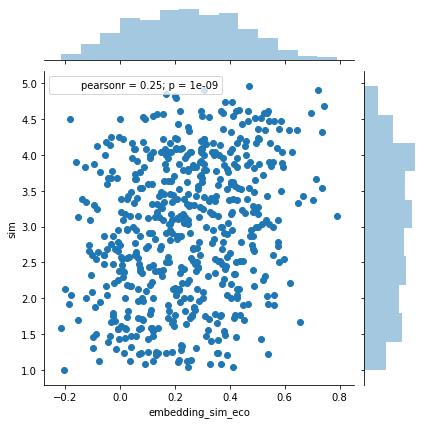

In [0]:
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
%matplotlib inline
sns.jointplot(data=df_Mturk.dropna(subset=['embedding_sim_eco']), x="embedding_sim_eco", y="sim").annotate(pearsonr)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


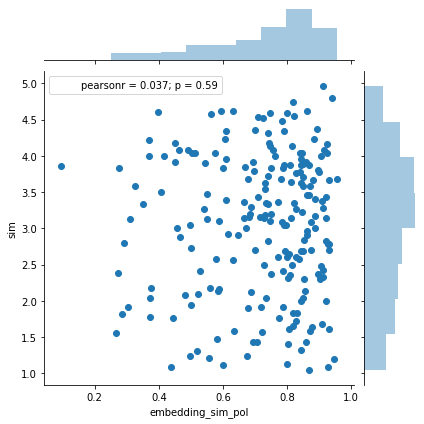

In [0]:
sns.jointplot(data=df_Mturk.dropna(subset=['embedding_sim_pol']), x="embedding_sim_pol", y="sim").annotate(pearsonr)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


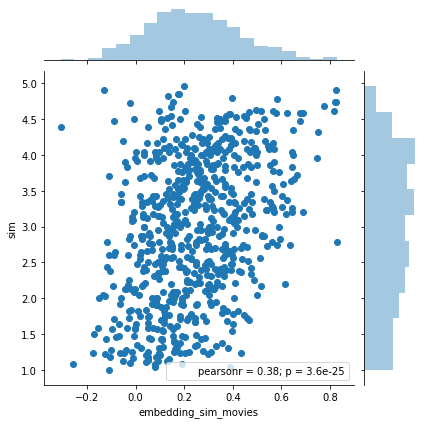

In [0]:
sns.jointplot(data=df_Mturk.dropna(subset=['embedding_sim_movies']), x="embedding_sim_movies", y="sim").annotate(pearsonr)

As expected, the movies embeddings performs better on the word similarity task than the economics, and politics embeddings. 

Intrinstic quality comparison is the following : 
movies > eco > pol.

This can be explained by the facts that :
- The movies corpus is the largest
- The movies corpus is the cleanest
- The economics corpus contains more domain-specific vocabulary that is not assessed by Mturk. 
- Politics and economics don't have some words that are in Mturk, and are thus not evaluated on that. 



Interested student could tune word2vec models hyperparameters to optimize the pearson coefficient, as an exercise. 